In [ ]:
!pip install transformer_lens

In [ ]:
"""
GENDER BIAS DETECTION IN GPT-2
================================
Discovers which attention heads cause gender bias using activation patching.
"""

import torch
from transformer_lens import HookedTransformer
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

print("✓ Imports successful")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✓ Imports successful
✓ PyTorch version: 2.9.0+cpu
✓ Device: CPU


In [ ]:
class BiasTracer:
    """
    Discovers and ablates gender bias in transformer models.

    Uses activation patching to identify which attention heads
    store gender associations.

    Example:
        tracer = BiasTracer("gpt2-small")
        bias = tracer.calculate_bias(
            "The doctor asked for the chart because",
            "The nurse asked for the chart because",
            "he", "she"
        )
    """

    def __init__(self, model_name="gpt2-small"):
        """Initialize with a HuggingFace model."""
        self.score = 0.0
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        print(f"Loading {model_name}...")
        self.model = HookedTransformer.from_pretrained(
            model_name,
            device=self.device
        )
        self.model.eval()

        self.n_layers = self.model.cfg.n_layers
        self.n_heads = self.model.cfg.n_heads
        self.heatmap = torch.zeros((self.n_layers, self.n_heads))

        print(f"✓ Model loaded: {self.n_layers} layers, {self.n_heads} heads per layer")

    def _get_logit_diff(self, logits, target_idx, counter_idx):
        """
        Calculate bias as difference in logits.

        Positive = prefers target word
        Negative = prefers counter word
        """
        return logits[0, -1, target_idx] - logits[0, -1, counter_idx]

    def validate_tokens(self, clean_text, corrupt_text):
        """Ensure both prompts tokenize to same length."""
        clean_toks = self.model.to_tokens(clean_text)
        corr_toks = self.model.to_tokens(corrupt_text)

        if clean_toks.shape[1] != corr_toks.shape[1]:
            raise ValueError(
                f"Token length mismatch: {clean_toks.shape[1]} vs {corr_toks.shape[1]}\n"
                f"Clean:   '{clean_text}'\n"
                f"Corrupt: '{corrupt_text}'"
            )

        return clean_toks, corr_toks

    def calculate_bias(self, clean_text, corrupt_text, target_word, counter_word):
        """
        Measure baseline bias between two prompts.

        Args:
            clean_text: Biased prompt (e.g., "The doctor...")
            corrupt_text: Counter prompt (e.g., "The nurse...")
            target_word: Word we expect model to prefer (e.g., "he")
            counter_word: Alternative word (e.g., "she")

        Returns:
            Logit difference (positive = biased toward target)
        """
        clean_toks, _ = self.validate_tokens(clean_text, corrupt_text)
        target_id = self.model.to_single_token(" " + target_word.strip())
        counter_id = self.model.to_single_token(" " + counter_word.strip())

        logits, _ = self.model.run_with_cache(clean_toks)
        return self._get_logit_diff(logits, target_id, counter_id)

    def find_top_heads(self, clean_text, corrupt_text, target, counter, top_k=5):
        """
        Discover which attention heads drive gender bias.

        Uses activation patching: for each head, swap its activations
        from clean→corrupt and measure the change in bias.

        Args:
            clean_text: Biased prompt
            corrupt_text: Counter prompt
            target: Expected word
            counter: Alternative word
            top_k: Number of top heads to return

        Returns:
            List of (layer, head) tuples ranked by impact
        """
        clean_toks, corr_toks = self.validate_tokens(clean_text, corrupt_text)
        target_id = self.model.to_single_token(" " + target)
        counter_id = self.model.to_single_token(" " + counter)

        # Get "clean" activations (source of bias signal)
        _, clean_cache = self.model.run_with_cache(clean_toks)

        print(f"Scanning {self.n_layers * self.n_heads} attention heads...")

        # Progress tracking
        total_heads = self.n_layers * self.n_heads
        progress_interval = max(1, total_heads // 10)

        # Define patching hook
        def patch_head_hook(activations, hook, head_idx, clean_cache):
            """Replace this head's activations with clean activations."""
            activations[:, :, head_idx, :] = clean_cache[hook.name][:, :, head_idx, :]
            return activations

        # Scan all heads
        count = 0
        for layer in range(self.n_layers):
            for head in range(self.n_heads):
                hook_name = f"blocks.{layer}.attn.hook_z"
                hook_fn = partial(
                    patch_head_hook,
                    head_idx=head,
                    clean_cache=clean_cache
                )

                # Run corrupt prompt with patched head
                patched_logits = self.model.run_with_hooks(
                    corr_toks,
                    fwd_hooks=[(hook_name, hook_fn)]
                )

                # Measure new bias
                self.score = self._get_logit_diff(
                    patched_logits, target_id, counter_id
                )
                self.heatmap[layer, head] = self.score.item()

                count += 1
                if count % progress_interval == 0:
                    print(f"  Progress: {count}/{total_heads} heads scanned...")

        # Find top K heads by impact
        top_scores, top_indices = torch.topk(self.heatmap.flatten(), top_k)

        results = []
        for idx in top_indices:
            layer = idx.item() // self.n_heads
            head = idx.item() % self.n_heads
            score = self.heatmap[layer, head].item()
            results.append((layer, head, score))

        print("✓ Scan complete!")
        return results

    def ablate_top_heads(self, clean_text, corrupt_text, target, counter, top_k=5):
        """
        Remove the top K biased heads and measure new bias.

        Args:
            Same as find_top_heads()

        Returns:
            (new_bias, list of ablated heads)
        """
        # Find culprits
        head_scores = self.find_top_heads(
            clean_text, corrupt_text, target, counter, top_k
        )
        heads_to_ablate = [(l, h) for l, h, _ in head_scores]

        print(f"\nAblating heads: {heads_to_ablate}")

        # Define ablation hook (zeros out activations)
        def multi_head_ablation_hook(activations, hook):
            layer_idx = int(hook.name.split(".")[1])
            for (l, h) in heads_to_ablate:
                if l == layer_idx:
                    activations[:, :, h, :] = 0
            return activations

        # Apply hooks to all affected layers
        hooks = []
        for (l, h) in heads_to_ablate:
            hook_name = f"blocks.{l}.attn.hook_z"
            hooks.append((hook_name, multi_head_ablation_hook))

        # Measure new bias on clean prompt
        clean_tokens, _ = self.validate_tokens(clean_text, corrupt_text)
        target_id = self.model.to_single_token(" " + target)
        counter_id = self.model.to_single_token(" " + counter)

        logits = self.model.run_with_hooks(clean_tokens, fwd_hooks=hooks)
        new_bias = self._get_logit_diff(logits, target_id, counter_id)

        return new_bias, head_scores

    def visualize_heatmap(self, title="Gender Bias Heatmap"):
        """Display heatmap of head impacts."""
        plt.figure(figsize=(12, 8))
        im = plt.imshow(
            self.heatmap.cpu().numpy(),
            origin="lower",
            aspect="auto",
            cmap="RdBu_r",
            vmin=-3, vmax=3
        )
        plt.colorbar(im, label="Bias Impact (Red = Pro-Bias, Blue = Anti-Bias)")
        plt.xlabel("Attention Head", fontsize=12)
        plt.ylabel("Layer", fontsize=12)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xticks(range(self.n_heads))
        plt.yticks(range(self.n_layers))
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    def print_head_rankings(self, head_scores):
        """Pretty print the top biased heads."""
        print("\n" + "="*60)
        print("TOP BIASED ATTENTION HEADS")
        print("="*60)
        for i, (layer, head, score) in enumerate(head_scores, 1):
            print(f"{i}. Layer {layer:2d}, Head {head:2d} → Impact: {score:+.4f}")
        print("="*60)

print("✓ BiasTracer class defined")

✓ BiasTracer class defined


In [ ]:
# Create tracer instance
tracer = BiasTracer("gpt2-small")

Loading gpt2-small...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
✓ Model loaded: 12 layers, 12 heads per layer


In [ ]:
# Define our test prompts
clean_prompt = "The doctor asked for the chart because"
corrupt_prompt = "The nurse asked for the chart because"

print("Test Configuration:")
print(f"  Clean (biased):   '{clean_prompt}'")
print(f"  Corrupt (counter): '{corrupt_prompt}'")
print(f"  Target word:      'he'")
print(f"  Counter word:     'she'")

Test Configuration:
  Clean (biased):   'The doctor asked for the chart because'
  Corrupt (counter): 'The nurse asked for the chart because'
  Target word:      'he'
  Counter word:     'she'


In [ ]:
print("\n" + "="*60)
print("STEP 1: MEASURING BASELINE BIAS")
print("="*60)

baseline_bias = tracer.calculate_bias(
    clean_prompt,
    corrupt_prompt,
    "he",
    "she"
)

print(f"\nBaseline bias score: {baseline_bias:.4f}")
print(f"Interpretation: Model prefers '{'he' if baseline_bias > 0 else 'she'}' for doctors")


STEP 1: MEASURING BASELINE BIAS

Baseline bias score: 1.1266
Interpretation: Model prefers 'he' for doctors


In [ ]:
print("\n" + "="*60)
print("STEP 2: DISCOVERING BIASED ATTENTION HEADS USING ACTIVATION MAPPING")
print("="*60)
print("This will take ~2-3 minutes...\n")

# Find top 5 most biased heads
top_heads = tracer.find_top_heads(
    clean_prompt,
    corrupt_prompt,
    "he",
    "she",
    top_k=5
)

# Display results
tracer.print_head_rankings(top_heads)


STEP 2: DISCOVERING BIASED ATTENTION HEADS USING ACTIVATION MAPPING
This will take ~2-3 minutes...

Scanning 144 attention heads...
  Progress: 14/144 heads scanned...
  Progress: 28/144 heads scanned...
  Progress: 42/144 heads scanned...
  Progress: 56/144 heads scanned...
  Progress: 70/144 heads scanned...
  Progress: 84/144 heads scanned...
  Progress: 98/144 heads scanned...
  Progress: 112/144 heads scanned...
  Progress: 126/144 heads scanned...
  Progress: 140/144 heads scanned...
✓ Scan complete!

TOP BIASED ATTENTION HEADS
1. Layer 10, Head  9 → Impact: -0.8818
2. Layer  9, Head  7 → Impact: -1.2925
3. Layer  4, Head  3 → Impact: -2.1279
4. Layer  8, Head 11 → Impact: -2.1341
5. Layer  9, Head  2 → Impact: -2.2086



STEP 3: VISUALIZING BIAS DISTRIBUTION


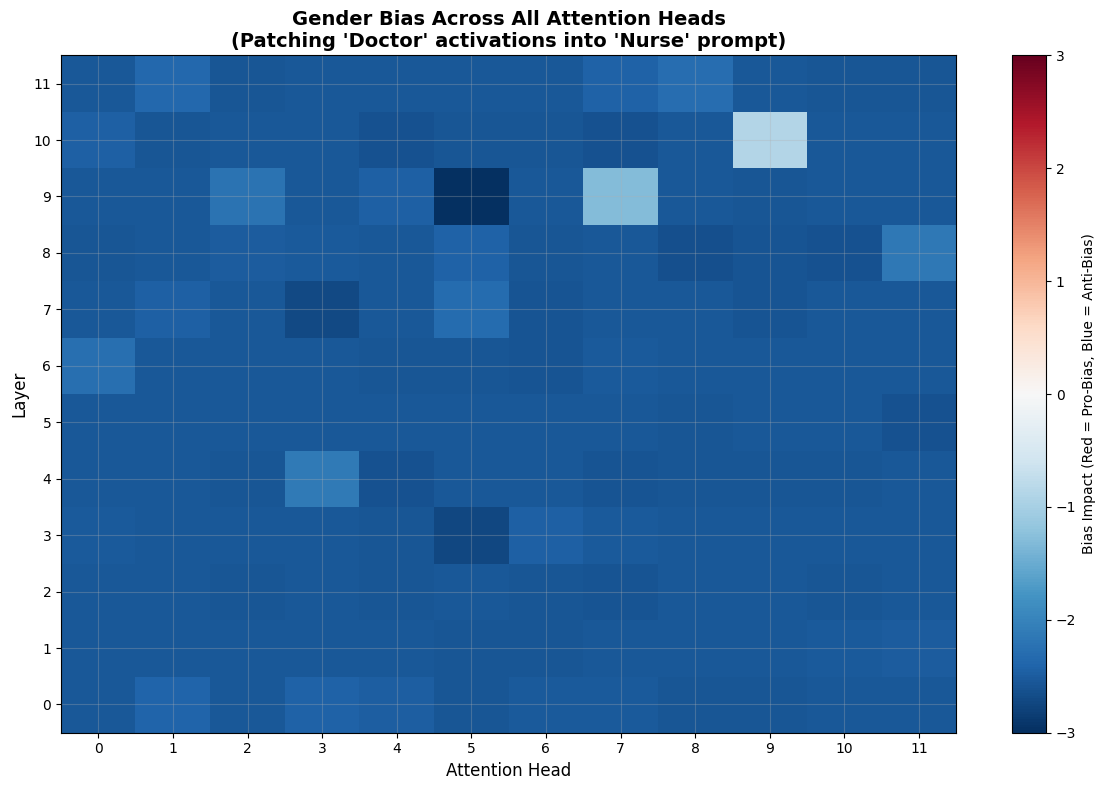

In [ ]:
print("\n" + "="*60)
print("STEP 3: VISUALIZING BIAS DISTRIBUTION")
print("="*60)

tracer.visualize_heatmap(
    title="Gender Bias Across All Attention Heads\n(Patching 'Doctor' activations into 'Nurse' prompt)"
)


In [ ]:
print("\n" + "="*60)
print("STEP 4: ABLATING BIASED HEADS FOUND THROUGH ACTIVATION MAPPING")
print("="*60)

new_bias, ablated_heads = tracer.ablate_top_heads(
    clean_prompt,
    corrupt_prompt,
    "he",
    "she",
    top_k=5
)

# Calculate reduction
reduction_percent = (1 - abs(new_bias.item()) / abs(baseline_bias.item())) * 100

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"Original bias:     {baseline_bias:.4f}")
print(f"After ablation:    {new_bias.item():.4f}")
print(f"Reduction:         {reduction_percent:.1f}%")
print(f"Heads removed:     {len(ablated_heads)}")
print("="*60)

if reduction_percent > 90:
    print("🎉 EXCELLENT: Bias almost completely eliminated!")
elif reduction_percent > 70:
    print("✓ GOOD: Significant bias reduction achieved")
elif reduction_percent > 50:
    print("⚠ MODERATE: Some bias remains")
else:
    print("❌ POOR: Minimal impact")


STEP 4: ABLATING BIASED HEADS FOUND THROUGH ACTIVATION MAPPING
Scanning 144 attention heads...
  Progress: 14/144 heads scanned...
  Progress: 28/144 heads scanned...
  Progress: 42/144 heads scanned...
  Progress: 56/144 heads scanned...
  Progress: 70/144 heads scanned...
  Progress: 84/144 heads scanned...
  Progress: 98/144 heads scanned...
  Progress: 112/144 heads scanned...
  Progress: 126/144 heads scanned...
  Progress: 140/144 heads scanned...
✓ Scan complete!

Ablating heads: [(10, 9), (9, 7), (4, 3), (8, 11), (9, 2)]

RESULTS SUMMARY
Original bias:     1.1266
After ablation:    0.3092
Reduction:         72.6%
Heads removed:     5
✓ GOOD: Significant bias reduction achieved


In [ ]:
print("\n" + "="*60)
print("VALIDATION: IDENTITY CHECK")
print("="*60)
print("Testing if patching mechanism is transparent...")
print("(Patching 'Nurse'→'Nurse' should change nothing)\n")

# Run identity check
nurse_tokens = tracer.model.to_tokens(corrupt_prompt)
nurse_logits, nurse_cache = tracer.model.run_with_cache(nurse_tokens)

he_token = tracer.model.to_single_token(" he")
she_token = tracer.model.to_single_token(" she")

baseline_nurse_bias = tracer._get_logit_diff(
    nurse_logits, he_token, she_token
).item()

# Patch nurse→nurse (identity operation)
def identity_hook(activations, hook):
    activations[:, :, 0, :] = nurse_cache[hook.name][:, :, 0, :]
    return activations

identity_logits = tracer.model.run_with_hooks(
    nurse_tokens,
    fwd_hooks=[("blocks.9.attn.hook_z", identity_hook)]
)

identity_bias = tracer._get_logit_diff(
    identity_logits, he_token, she_token
).item()

difference = abs(baseline_nurse_bias - identity_bias)

print(f"Baseline (Nurse):  {baseline_nurse_bias:.6f}")
print(f"After identity patch: {identity_bias:.6f}")
print(f"Difference:        {difference:.2e}")

if difference < 1e-5:
    print("\n✅ PASSED: Patching mechanism is transparent")
    print("   (This proves our activation swapping works correctly)")
else:
    print(f"\n❌ FAILED: Unexpected difference of {difference:.6f}")
    print("   (This suggests a bug in the patching code)")


VALIDATION: IDENTITY CHECK
Testing if patching mechanism is transparent...
(Patching 'Nurse'→'Nurse' should change nothing)

Baseline (Nurse):  -2.546968
After identity patch: -2.546968
Difference:        0.00e+00

✅ PASSED: Patching mechanism is transparent
   (This proves our activation swapping works correctly)



SYSTEMATIC ABLATION STUDY
Ablating each head individually to measure importance...

Baseline bias (Doctor→he): 1.1266

Scanning all heads (this takes ~2 min)...
✓ Ablation scan complete!



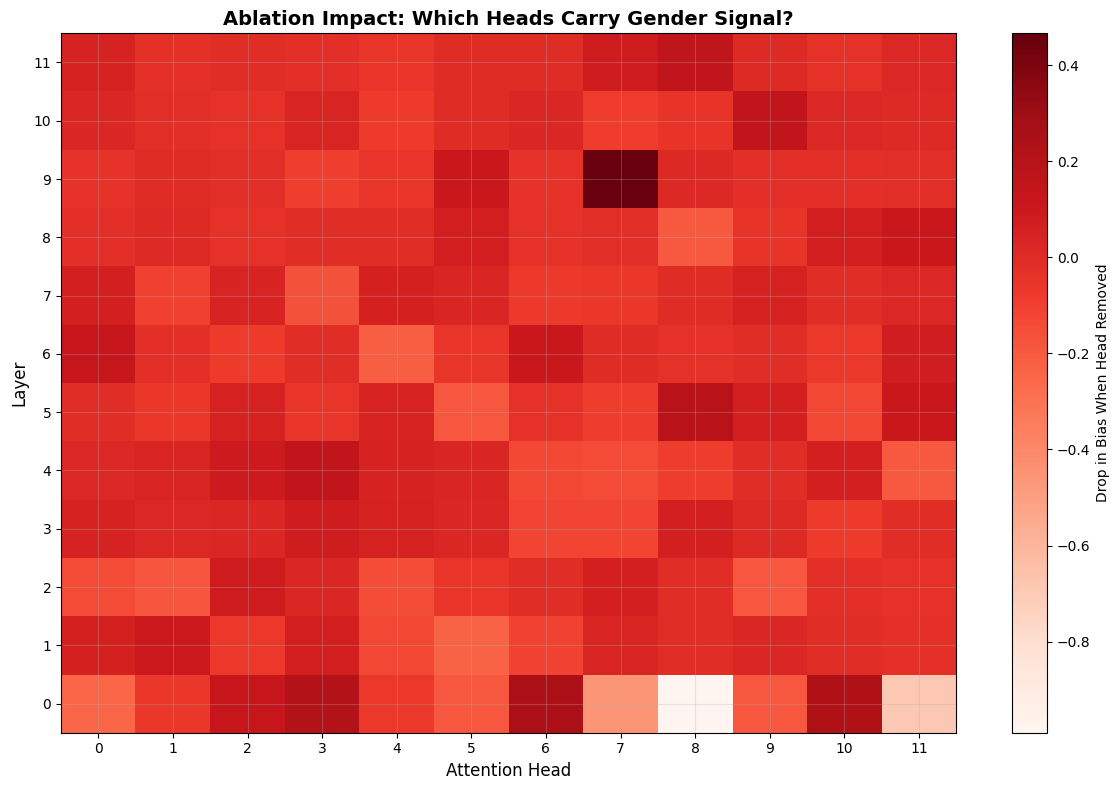


Top 5 Most Important Heads:
1. Layer  9, Head  7 → Impact: +0.4665
2. Layer  0, Head  6 → Impact: +0.2468
3. Layer  0, Head 10 → Impact: +0.2315
4. Layer  0, Head  3 → Impact: +0.2132
5. Layer  5, Head  8 → Impact: +0.1868


In [ ]:
print("\n" + "="*60)
print("SYSTEMATIC ABLATION STUDY")
print("="*60)
print("Ablating each head individually to measure importance...\n")

# This creates a different kind of heatmap
clean_tokens = tracer.model.to_tokens(clean_prompt)
he_token = tracer.model.to_single_token(" he")
she_token = tracer.model.to_single_token(" she")

# Get baseline
logits, _ = tracer.model.run_with_cache(clean_tokens)
baseline = tracer._get_logit_diff(logits, he_token, she_token).item()

print(f"Baseline bias (Doctor→he): {baseline:.4f}\n")

# Create ablation impact map
ablation_impact = torch.zeros((tracer.n_layers, tracer.n_heads))

def zero_head_hook(activations, hook, head_idx):
    """Kill a specific head."""
    activations[:, :, head_idx, :] = 0
    return activations

print("Scanning all heads (this takes ~2 min)...")
for layer in range(tracer.n_layers):
    for head in range(tracer.n_heads):
        hook_name = f"blocks.{layer}.attn.hook_z"
        hook_fn = partial(zero_head_hook, head_idx=head)

        ablated_logits = tracer.model.run_with_hooks(
            clean_tokens,
            fwd_hooks=[(hook_name, hook_fn)]
        )

        new_bias = tracer._get_logit_diff(
            ablated_logits, he_token, she_token
        ).item()

        # Positive damage = head was helping bias
        damage = baseline - new_bias
        ablation_impact[layer, head] = damage

print("✓ Ablation scan complete!\n")

# Visualize
plt.figure(figsize=(12, 8))
im = plt.imshow(
    ablation_impact.cpu().numpy(),
    origin="lower",
    aspect="auto",
    cmap="Reds"
)
plt.colorbar(im, label="Drop in Bias When Head Removed")
plt.xlabel("Attention Head", fontsize=12)
plt.ylabel("Layer", fontsize=12)
plt.title("Ablation Impact: Which Heads Carry Gender Signal?", fontsize=14, fontweight='bold')
plt.xticks(range(tracer.n_heads))
plt.yticks(range(tracer.n_layers))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find top 5 most important
flat_indices = torch.topk(ablation_impact.flatten(), 5).indices
print("\nTop 5 Most Important Heads:")
print("="*60)
for i, idx in enumerate(flat_indices, 1):
    l = idx.item() // tracer.n_heads
    h = idx.item() % tracer.n_heads
    impact = ablation_impact[l, h].item()
    print(f"{i}. Layer {l:2d}, Head {h:2d} → Impact: {impact:+.4f}")
print("="*60)

In [ ]:
# The suspects identified from your tensor
suspects = [(9, 7), (0,6), (0,10), (0,3), (5,8)]

print(f"Testing ablation on suspects: {suspects}")

def specific_ablation_hook(activations, hook):
    layer = int(hook.name.split(".")[1])
    for (l, h) in suspects:
        if l == layer:
            activations[:, :, h, :] = 0 # Kill the head
    return activations

# Run on the original biased prompt ("The doctor...")
clean_tokens = tracer.model.to_tokens("The doctor asked for the chart because")

# 1. Baseline Bias
logits, _ = tracer.model.run_with_cache(clean_tokens)
baseline = tracer._get_logit_diff(logits, tracer.model.to_single_token(" he"), tracer.model.to_single_token(" she"))
print(f"Original Bias (Doctor): {baseline.item():.4f}")

# 2. Ablated Bias
hooks = []
for (l, h) in suspects:
    hooks.append((f"blocks.{l}.attn.hook_z", specific_ablation_hook))

ablated_logits = tracer.model.run_with_hooks(clean_tokens, fwd_hooks=hooks)
new_bias = tracer._get_logit_diff(ablated_logits, tracer.model.to_single_token(" he"), tracer.model.to_single_token(" she"))
print(f"Bias after killing the most chaotic ones: {new_bias.item():.4f}")

Testing ablation on suspects: [(9, 7), (0, 6), (0, 10), (0, 3), (5, 8)]
Original Bias (Doctor): 1.1266
Bias after killing the most chaotic ones: 0.0287
